# Introduction

Dalam notebook ini, kita akan membuat image classification model yang dapat mengenali handwritten digits (0,1,..,9) dengan menggunakan pre-trained model MobileNetV2 pada dataset MNIST. 

Arsitektur MobileNetV2 dipilih karena memiliki arsitektur yang ringan, sehingga lebih cepat dalam proses pelatihan dan inferensi, dan memberikan akurasi yang baik dalam klasifikasi gambar. Selain itu, arsitektur ini juga dilengkapi dengan teknik seperti depthwise separable convolution yang dapat mengurangi jumlah parameter dan mengurangi waktu pelatihan

Pertama, kita perlu mengimpor setiap library/modul yang dibutuhkan. kita membutuhkan library tensorflow, pandas, matplotlib, numpy, sklearn, dan random

In [58]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random

In [59]:
df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
df.shape

(42000, 785)

Data tersebut memiliki 42ribu baris dan 785 kolom, kolom pertama berisi label digit (0-9), sedangkan kolom lainnya berisi nilai piksel dari gambar digit

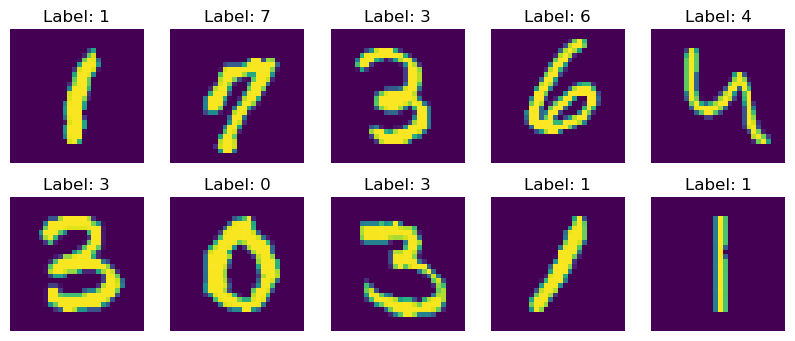

In [61]:
fig = plt.figure(figsize=(10, 4))
for i in range(10):
    idx = random.randint(0, len(df))
    plt.subplot(2, 5, i+1)
    plt.imshow(df.iloc[idx, 1:].values.reshape(28, 28))
    plt.axis(False)
    plt.title(f"Label: {df['label'][idx]}")

# Data Preparation

Di bagian ini, kita akan mempersiapkan dataset MNIST untuk dijadikan sebagai input dari model.

Pertama, kita perlu membagi menjadi train set dan validation set dengan rasio 80:20

In [62]:
# Membagi dataset menjadi train set dan validation set
train_set, val_set = train_test_split(df, test_size=0.2, random_state=42)
train_set.shape, val_set.shape

((33600, 785), (8400, 785))

Selanjutnya, data train dan validation set diubah menjadi bentuk tensor menggunakan `tf.constant` dan `tf.one_hot` untuk membuat one-hot encoded labels pada kolom "label".

In [63]:
# Mengubah ke dalam bentuk tensor
X_train = tf.constant(train_set.iloc[:, 1:].values, shape=(len(train_set), 28, 28))
y_train = tf.one_hot(train_set["label"].values, 10)
X_val = tf.constant(val_set.iloc[:, 1:].values, shape=(len(val_set), 28, 28))
y_val = tf.one_hot(val_set["label"].values, 10)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

(TensorShape([33600, 28, 28]),
 TensorShape([33600, 10]),
 TensorShape([8400, 28, 28]),
 TensorShape([8400, 10]))

Setelah itu, data train dan validation set diubah menjadi bentuk batch berukuran 32 menggunakan `tf.data.Dataset` dan fungsi `batch` sehingga dapat digunakan sebagai input untuk model image classification.

In [64]:
# Mengubah ke dalam bentuk batch berukuran 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(train_set))
train_dataset = train_dataset.batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(32)

# Model Architecture

Kita akan menggunakan arsitektur MobileNetV2 sebagai feature extractor. kita tidak membutuhkan layer output default dari MobileNetV2, kita perlu membuat sendiri karena pada kasus ini jumlah class dari outputnya adalah 10 yang terdiri dari digit 0-9. oleh karena itu, kita menggunakan parameter `include_top=False` untuk menghilangkan layer terakhir pada model MobileNetV2. 

Selain itu, weights='imagenet' digunakan agar kita dapat menggunakan weights model yang sudah dilatih pada dataset imagenet.

Arsitektur MobileNetV2
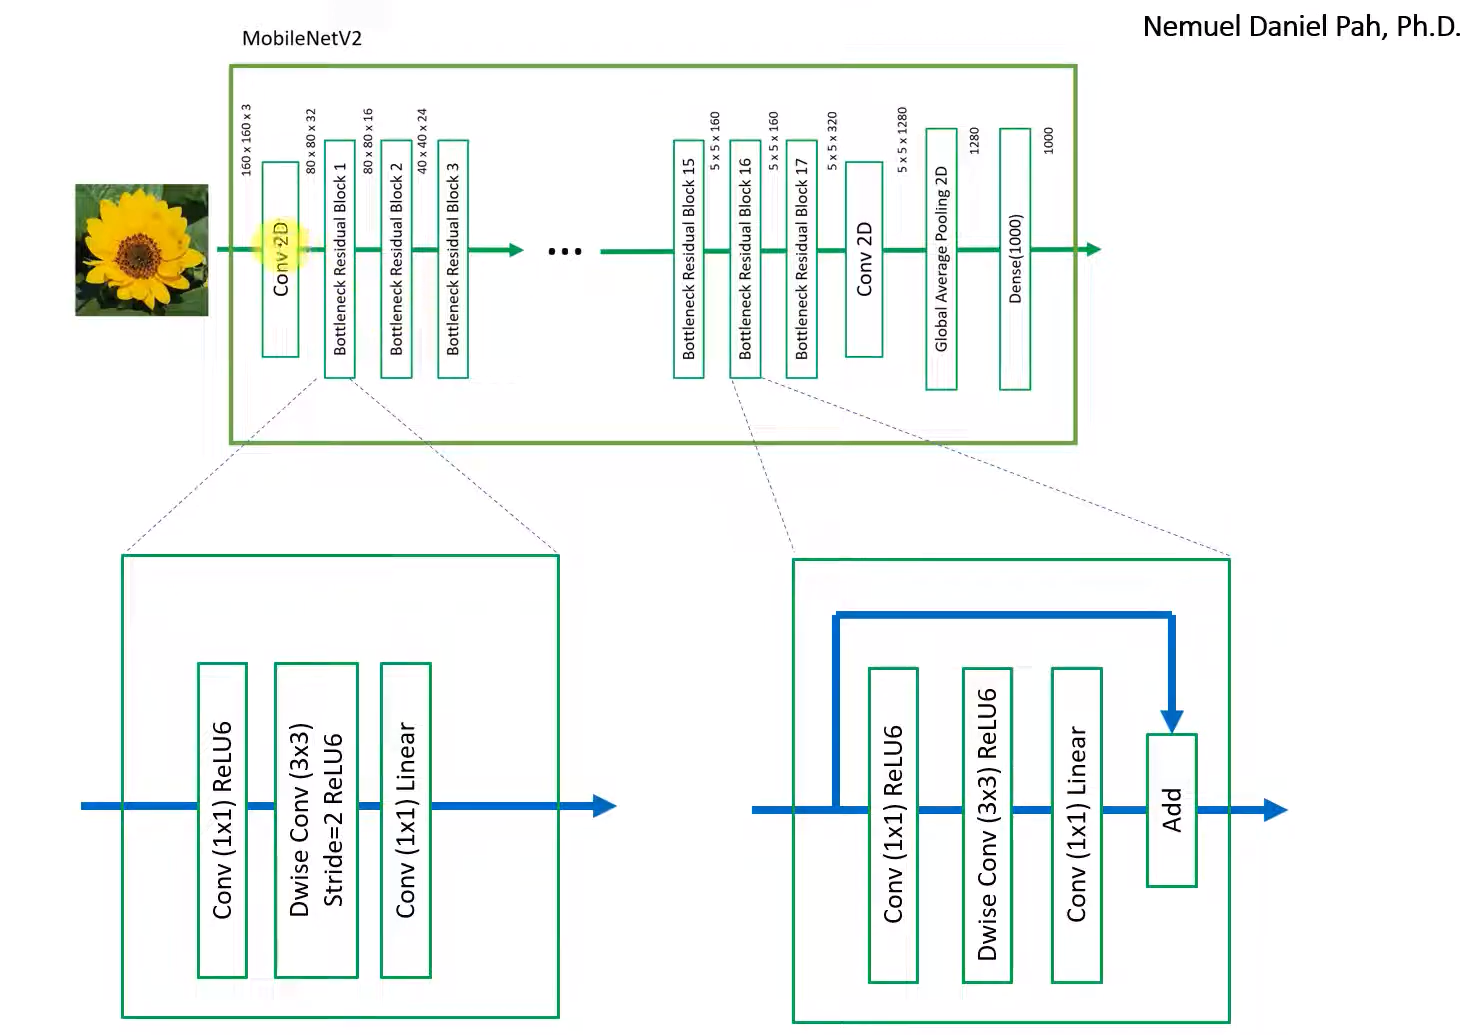

*source* : https://www.youtube.com/watch?v=1Ug7LrulKlM

In [65]:
MobileNetV2 = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, 
                                                             weights='imagenet')

Setelah itu, kita mengatur agar semua layer pada MobileNetV2 tidak dapat di-training ulang dengan menggunakan `MobileNetV2.trainable = False`. Hal ini dikarenakan kita hanya ingin menggunakan model MobileNetV2 sebagai feature extractor untuk mengekstraksi fitur dari gambar, dan tidak ingin mengubah bobot-bobot yang sudah dilatih pada model MobileNetV2.

In [66]:
MobileNetV2.trainable = False

In [67]:
inputs = tf.keras.Input(shape=(28, 28))
x = tf.expand_dims(inputs, axis=-1)
x = tf.keras.layers.Resizing(160, 160, interpolation="bilinear")(x)
x = tf.keras.layers.Lambda(lambda  t: tf.tile(t, [1, 1, 1, 3]))(x)
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(x)
x = MobileNetV2(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [68]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, 28, 28, 1)        0         
 a)                                                              
                                                                 
 resizing_1 (Resizing)       (None, 160, 160, 1)       0         
                                                                 
 lambda_1 (Lambda)           (None, 160, 160, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                    

Input gambar berukuran 28x28 akan diubah menjadi ukuran 160x160 menggunakan layer Resizing, kemudian dilakukan ekspansi dimensi ke tiga menggunakan Lambda layer. Selanjutnya, nilai pixel gambar akan dinormalisasi dengan Rescaling layer. Output dari MobileNetV2 akan diambil dengan menggunakan GlobalAveragePooling2D, kemudian disambungkan dengan Dense layer berukuran 10 untuk melakukan klasifikasi pada 10 kelas digit yang ada pada dataset MNIST.

Total parameter dari model ini adalah 2.270.794, yang terdiri dari 2.257.984 parameter yang tidak dapat diubah pada layer MobileNetV2 dan 12.810 parameter yang dapat diubah pada layer output `dense`.

In [69]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="CategoricalCrossentropy",
              metrics=["accuracy"])

 Model akan di-compile dengan optimizer Adam, loss function Categorical Crossentropy, dan accuracy sebagai metrik evaluasi. Dengan melakukan compile pada model, kita dapat menentukan cara model belajar dan bagaimana kita ingin mengukur kinerja model.

# Model Training


In [70]:
history = model.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=len(train_dataset),
                    validation_data=val_dataset,
                    validation_steps=int(len(val_dataset)))

Epoch 1/5
1050/1050 [==============================] - 32s 28ms/step - loss: 0.2802 - accuracy: 0.9191 - val_loss: 0.1571 - val_accuracy: 0.9517
Epoch 2/5
1050/1050 [==============================] - 29s 28ms/step - loss: 0.1227 - accuracy: 0.9628 - val_loss: 0.1058 - val_accuracy: 0.9673
Epoch 3/5
1050/1050 [==============================] - 29s 28ms/step - loss: 0.0937 - accuracy: 0.9725 - val_loss: 0.0956 - val_accuracy: 0.9708
Epoch 4/5
1050/1050 [==============================] - 29s 28ms/step - loss: 0.0786 - accuracy: 0.9761 - val_loss: 0.0857 - val_accuracy: 0.9733
Epoch 5/5
1050/1050 [==============================] - 29s 28ms/step - loss: 0.0685 - accuracy: 0.9787 - val_loss: 0.0809 - val_accuracy: 0.9736


Kita dapat melihat hasil performa model saat dilatih selama 5 epoch. Pada epoch pertama, model memiliki loss function sebesar 0.2822 dan akurasi sebesar 0.9184 pada data training, serta val_loss sebesar 0.1439 dan val_accuracy sebesar 0.9581 pada data validasi. Pada setiap epoch selanjutnya, model berhasil mengurangi loss function dan meningkatkan akurasi pada data training maupun data validasi, menunjukkan bahwa model semakin baik dalam memprediksi hasil dengan data yang diberikan. Pada epoch terakhir, model memiliki loss function sebesar 0.0686 dan akurasi sebesar 0.9793 pada data training, serta val_loss sebesar 0.0801 dan val_accuracy sebesar 0.9749 pada data validasi.

# Model Evaluation

In [71]:
model.evaluate(val_dataset)

263/263 [==============================] - 6s 22ms/step - loss: 0.0809 - accuracy: 0.9736


[0.0808895006775856, 0.9735714197158813]

Berdasarkan output dari evaluasi model, dapat disimpulkan bahwa model telah mencapai akurasi sebesar 97.49% pada data validasi. Selain itu, nilai loss pada data validasi sebesar 0.0801 menunjukkan bahwa model cukup baik dalam meminimalkan kesalahan prediksi pada data yang belum pernah dilihat sebelumnya. Dengan demikian, dapat dikatakan bahwa model telah cukup baik dalam melakukan klasifikasi gambar pada dataset yang digunakan.

# Making Predictions

In [72]:
test_set = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test_set = tf.constant(test_set.values, shape=(len(test_set), 28, 28))
p = model.predict(test_set)

875/875 [==============================] - 18s 20ms/step


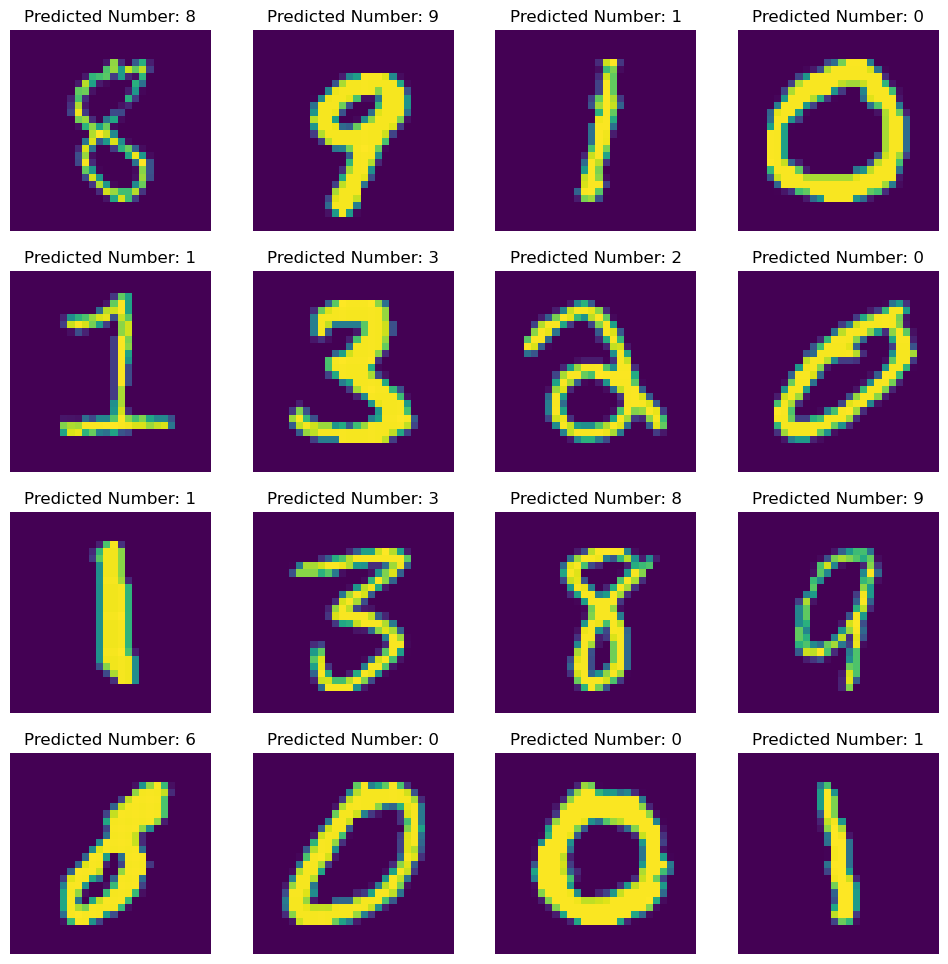

In [73]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 17):
    idx = random.randint(0, len(test_set))
    plt.subplot(4, 4, i)
    plt.imshow(test_set[idx])
    plt.axis(False)
    plt.title(f"Predicted Number: {p[idx].argmax()}")

In [74]:
result = np.argmax(p, axis=1)
result = pd.Series(result, name="Label")
submission = pd.concat([pd.Series(range(1,28001) , name = "ImageId"), result], axis = 1)
submission.to_csv("submission.csv",index=False)